# Setup (virtual environment)

In [1]:
import keras
import pickle 
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.iv.nnet import DeepIV
from keras.models import load_model
%matplotlib inline

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


- gpu check

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


In [4]:
keras.__version__

'2.6.0'

In [5]:
tf.__version__

'2.6.0'

# Temp Functions

In [6]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


def update_dummy_columns(row):
    row['brand_rename_{}'.format(row["brand_rename"])] = 1
    row['yyyy_{}'.format(row["yyyy"])] = 1
    row['mm_{}'.format(row["mm"])] = 1
    row['category_1_{}'.format(row["category_1"])] = 1
    return row

# 1. Load Data

In [7]:
df_model = pd.read_feather('../data/DeepIV v2.0.0.ftr')
df_model = df_model[df_model['itt_hour_ln'].notnull()]

In [8]:
df_model[['premium_perc']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
premium_perc,16242602.0,0.362053,0.994836,-0.938326,-0.383333,-0.090909,0.137466,0.508475,1.671756,40.936714


In [9]:
print(df_model.shape)
display(df_model.head())
display(df_model.tail())

(16242602, 219)


,product_id,txn_id,yyyymm,yyyy,mm,category_1,option_rename,brand_rename,itt_hour_ln,premium_perc,msrp_dollar_ln,brand_likes_ln,with_release_date,days_since_release_ln,likes_count_cumsum,wish_closest_product,likes_count_cumsum_1k,likes_count_cumsum_ln,wish_closest_product_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199
0,42255,11749,2022-07,2022,07,shoes,280,Nike,0.065580,0.278539,5.132626,10.735875,1,5.690359,53713.0,6472,53.713,10.891429,8.775395,1.22469,-0.068803,-0.165689,0.231437,-1.084858,0.256292,0.415015,-0.227768,-0.888845,-0.777399,0.636129,-2.119525,-0.447786,0.089478,-0.502632,0.050769,-0.654228,0.327182,-0.983476,1.273388,0.420625,0.321297,0.336137,0.895122,0.630526,0.752017,1.151641,0.536488,-0.373947,-0.356338,0.716691,1.870043,-0.841526,0.212666,1.716576,0.692349,0.802514,0.975076,0.112449,2.155179,0.960115,-0.547129,-0.17001,-1.035996,-0.439908,-1.346315,0.072468,0.056531,0.257154,-0.082497,0.337566,-0.31292,-0.740532,-0.389157,0.510196,-0.937762,0.736678,1.474665,-0.98012,0.177215,0.14049,-0.481794,-0.329441,0.192831,-3.064365,0.399116,0.964035,-0.313681,-0.414518,0.145605,-0.808144,-0.044025,-0.981735,0.64008,-0.945151,-0.905621,-0.037038,-1.035742,-0.995792,0.05709,-0.454395,1.101,-0.925124,-0.54241,0.219101,0.580851,-0.199081,-2.34045,0.525597,2.211424,-0.045361,0.144549,-0.036955,-0.004316,0.632533,-1.208875,0.410856,-1.548137,1.260532,-0.602752,2.351831,0.123617,-0.013077,0.101594,0.529271,1.029166,-0.573539,-0.799114,1.177625,0.096283,0.207712,0.217883,0.42239,0.608486,0.209811,-0.215024,-0.341872,0.202803,0.485655,-0.3825,0.699943,-0.014483,0.188041,1.504936,0.656583,-0.325894,1.652314,-1.215782,-0.927659,0.703655,-0.354598,-0.776105,-0.500065,1.06088,1.136179,-0.085494,0.126708,0.632443,-0.386884,0.828545,0.031802,1.975619,0.244726,0.645747,1.195078,1.302619,-0.732204,1.797579,0.592243,0.285388,-2.318031,-0.480669,-0.670451,1.333989,-0.502607,1.093512,-0.018615,0.104193,0.864382,-0.211901,1.113408,-1.04747,0.509298,-1.028491,-0.447527,0.199242,0.822213,0.144856,-0.590723,-0.97767,-1.643461,-0.647337,0.152546,-0.224191,1.969188,-0.029888,0.094336,-1.061821,0.965716,-0.180795,2.026757,0.243806,0.525163,0.025808,0.939593,-0.901696,0.747443,-0.540636,-0.05331,0.000174,-0.104929,0.621431,-0.007889,-0.072259,1.147274,0.570283,1.450368,0.392464,-0.218876,-0.685819
1,42255,11748,2022-07,2022,07,shoes,270,Nike,1.176173,0.347032,5.132626,10.735875,1,5.690359,53713.0,6472,53.713,10.891429,8.775395,1.22469,-0.068803,-0.165689,0.231437,-1.084858,0.256292,0.415015,-0.227768,-0.888845,-0.777399,0.636129,-2.119525,-0.447786,0.089478,-0.502632,0.050769,-0.654228,0.327182,-0.983476,1.273388,0.420625,0.321297,0.336137,0.895122,0.630526,0.752017,1.151641,0.536488,-0.373947,-0.356338,0.716691,1.870043,

,product_id,txn_id,yyyymm,yyyy,mm,category_1,option_rename,brand_rename,itt_hour_ln,premium_perc,msrp_dollar_ln,brand_likes_ln,with_release_date,days_since_release_ln,likes_count_cumsum,wish_closest_product,likes_count_cumsum_1k,likes_count_cumsum_ln,wish_closest_product_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199
16283582,67193,5395,2023-06,2023,06,shoes,235,Adidas,0.020347,-0.072727,3.76833,10.200922,0,0.0,0.0,1542,0.0,0.0,7.341484,-0.863038,-0.835798,0.736526,-0.232819,-0.036609,0.490917,-0.544761,-0.300737,1.64756,-0.681606,1.664287,2.129067,0.208269,-1.12478,-0.420299,-1.596218,-0.068161,1.103696,1.124744,-0.484753,-0.162251,0.60301,0.173355,-0.731974,0.746066,-0.241666,-0.065543,-0.135097,0.468187,0.692275,1.548228,0.852855,-0.193092,2.347802,1.836273,-0.941752,2.531947,1.569453,-1.452588,-0.016491,0.578747,0.216561,-0.737154,0.205099,-0.210406,-0.811521,0.263732,0.637736,-0.044726,-0.889956,0.000803,-0.744161,1.372432,-0.458915,2.090288,0.465836,1.327892,-0.00988,2.094403,0.01783,2.236527,0.256328,0.377447,-0.564592,-0.097739,-0.683306,-1.099941,0.142905,-0.47991,-1.496485,-1.219003,-0.092071,-0.227957,0.454825,0.138029,-0.785493,0.875816,0.964246,-1.812101,0.105707,0.157228,0.010963,1.066068,1.166084,0.971527,1.826357,-0.888387,0.638323,0.281606,1.126166,-0.464523,-0.529752,-0.555807,0.484589,-0.200872,0.327824,1.064804,-0.642549,0.279791,-0.150773,2.169824,0.431053,-1.145573,0.152526,0.347126,-0.29328,0.948292,-0.082929,-0.366466,-0.162389,-0.290158,1.160556,-0.686018,-1.001142,0.061833,-0.659387,1.142287,-1.026193,0.888893,0.101181,-0.958304,0.935743,1.553727,0.781635,0.023971,-0.963533,-0.487225,0.359596,-1.275738,-1.516362,-0.750762,0.415438,-0.365464,0.899301,1.431341,-1.557612,0.153277,1.442848,0.536415,0.424554,1.153556,1.769685,-0.168875,0.804312,0.197324,0.717221,1.179438,0.39466,1.301962,-0.005655,-0.511392,-1.984895,0.225359,0.655855,1.095041,-1.253575,-2.056981,0.639951,1.378093,-0.045784,-0.223902,-0.147358,0.145004,-1.175388,-1.429002,-0.279713,1.015708,-0.372066,1.371267,-0.415817,-0.835525,-1.118245,0.21413,-0.767767,0.827604,-1.019923,-0.080564,-0.444665,-0.556113,0.65994,1.53626,1.719893,0.752104,0.752989,0.033709,0.141457,-1.430368,-1.112329,-0.212965,-1.274989,0.958892,0.728944,-1.213958,0.006024,-1.785552,-0.063978,-0.796492,0.428085,-1.564268,-1.397101
16283583,67193,5394,2023-06,2023,06,shoes,245,Adidas,0.044548,0.000000,3.76833,10.200922,0,0.0,0.0,1542,0.0,0.0,7.341484,-0.863038,-0.835798,0.736526,-0.232819,-0.036609,0.490917,-0.544761,-0.300737,1.64756,-0.681606,1.664287,2.129067,0.208269,-1.12478,-0.420299,-1.596218,-0.068161,1.103696,1.124744,-0.484753,-0.162251,0.60301,0.173355,-0.731974,0.746066,-0.241666,-0.065543,-0.135097,0.468187,0.692275,1.548228,0.852855,-0.19

# 13. Deep IV (241016 v5) --> chosen model
- early stopping patience=3
- epoch 200
- put Relu function on the response model
- same model with 241016 v1

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

,product_id,yyyymm,yyyy,mm,category_1,option_rename,brand_rename,itt_hour_ln,premium_perc,msrp_dollar_ln,brand_likes_ln,with_release_date,days_since_release_ln,likes_count_cumsum,wish_closest_product,likes_count_cumsum_1k,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199
11752,42258,2022-03,2022,03,shoes,275,Asics,6.718205,-0.047619,4.986238,9.569482,1,6.538140,0.0,1194,0.000,1.050903,0.111212,1.969807,0.246390,-1.691035,0.429657,0.948235,-0.536632,-1.214658,-0.964641,1.480959,-0.783705,0.466241,-0.688015,-0.412942,-0.143428,-0.314078,-0.618858,0.846497,0.046871,-0.369871,0.740456,0.270468,-3.159378,-0.857469,1.588793,-1.217684,-0.428428,0.095805,0.724780,-0.987395,-0.336328,-1.300317,1.505193,0.136826,-0.682188,0.549174,1.383650,-0.624311,-0.903093,-1.980773,-1.410958,1.597054,-0.529047,0.339531,-0.468913,-0.425969,1.543226,-1.785579,-0.188002,-0.285744,0.115115,0.814749,0.552214,0.258760,2.455998,2.441002,0.958385,-0.810862,-0.043659,-1.200132,-0.513133,0.002078,0.262982,0.750010,0.007721,0.886974,1.889386,0.673710,1.697085,0.573531,-0.833351,-0.274173,1.086972,1.557063,-0.015259,0.780419,1.263441,-0.892754,-0.955311,1.343573,0.180579,-0.279759,-0.841166,-0.093440,0.970204,-0.185627,0.945384,-1.068130,-0.095653,0.017614,0.280456,-1.016752,-1.516444,0.883557,0.974372,0.152502,-0.932634,0.149668,0.390631,-0.424544,0.296182,0.478034,0.949659,-0.580117,1.889204,-0.775365,0.878037,-0.902113,0.000008,-0.341880,-2.135886,-1.353765,1.258339,-0.477007,-0.910187,2.800293,-0.126397,0.536273,-1.821600,-0.763417,0.804305,-0.197647,0.471623,0.984216,0.834859,2.108625,-1.464944,-0.116608,1.068556,-1.195908,-0.303622,-1.502001,-0.449634,-0.412819,-0.958275,-0.668678,-0.247776,1.821137,-0.307650,-0.728938,-0.176951,1.875338,-0.655142,-0.430971,0.542584,0.069171,-0.441116,1.365279,-1.570143,1.970648,0.731082,-1.600580,0.962423,2.171850,-1.707627,0.779579,-0.725572,1.115834,-0.073132,-0.999555,1.364404,1.273509,1.786406,0.409843,-0.223621,-0.516963,-0.256378,1.111880,-2.348297,-0.012128,-0.408720,-0.579354,1.042635,-0.438674,1.133352,1.339580,0.010408,-1.043930,-0.447716,1.046107,-1.594402,-0.905545,0.947615,0.763743,0.483854,-0.270949,-0.197346,0.609775,0.130062,0.077838,0.149579,1.385741,-0.749670,-1.412760,-1.511567,0.025271,0.940335,-1.351055,0.503261
11815,42260,2021-10,2021,10,shoes,265,Converse,7.294702,-0.141414,4.345801,8.045588,0,0.000000,0.0,619,0.000,-1.738925,1.827212,-0.856622,0.113211,1.747071,-0.296775,0.624815,-1.126044,-1.021075,0.356013,-0.571247,2.460512,-0.971897,0.425472,1.226174,1.521232,0.047381,-1.149022,-0.584600,0.857650,0.634725,0.505800,-2.420990,-0.709899,-1.552438,-0.308961,0.159000,-0.196066,1.478492,0.908951,0.910422,-1.997564,-1.489222,0.377437,-0.054294,-0.430845,-2.168412,-0.198054,-0.060278,

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


,product_id,itt_hour_ln,premium_perc,msrp_dollar_ln,with_release_date,days_since_release_ln,likes_count_cumsum_1k,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyy_2020,yyyy_2021,yyyy_2022,yyyy_2023,yyyy_2024,mm_01,mm_02,mm_03,mm_04,mm_05,mm_06,mm_07,mm_08,mm_09,mm_10,mm_11,mm_12,brand_rename_A.P.C.,brand_rename_AMI,brand_rename_Acne Studios,brand_rename_Ader Error,brand_rename_Adidas,brand_rename_Alexander McQueen,brand_rename_Arc'teryx,brand_rename_Asics,brand_rename_Autry,brand_rename_BAPE,brand_rename_Balenciaga,brand_rename_Birkenstock,brand_rename_Bottega Veneta,brand_rename_Burberry,brand_rename_C.P. Company,brand_rename_CDG,brand_rename_COS,brand_rename_Cardinal Red,brand_rename_Carhartt,brand_rename_Carhartt WIP,brand_rename_Casio,brand_rename_Celine,brand_rename_Chanel,brand_rename_Clarks,brand_rename_Converse,brand_rename_Crocs,brand_rename_Dada,brand_rename_Darkr8m Studio,brand_rename_Deus Ex Machina,brand_rename_Diesel,brand_rename_Dior,brand_rename_Dr. Martens,brand_rename_Emis,brand_rename_Essentials,brand_rename_Ganni,brand_rename_Gentle Monster,brand_rename_Golden Goose,brand_rename_Gucci,brand_rename_Hermes,brand_rename_Hoka,brand_rename_Human Made,brand_rename_Hunter,brand_rename_IAB Studio,brand_rename_Jacquemus,brand_rename_Jansport,brand_rename_Jellycat,brand_rename_Jordan,brand_rename_Kaikai Kiki,brand_rename_Keen,brand_rename_Lemaire,brand_rename_Longchamp,brand_rename_Louis Vuitton,brand_rename_Maison Kitsune,brand_rename_Maison Margiela,brand_rename_Matin Kim,brand_rename_Mihara Yasuhiro,brand_rename_Mischief,brand_rename_Miu Miu,brand_rename_Monamhee,brand_rename_Moncler,brand_rename_Montblanc,brand_rename_Moonstar,brand_rename_New Balance,brand_rename_New Era,brand_rename_NewJeans,brand_rename_Nike,brand_rename_Oakley,brand_rename_Onitsuka Tiger,brand_rename_Oofos,brand_rename_Our Legacy,brand_rename_Palace,brand_rename_Patagonia,brand_rename_Porter,brand_rename_Prada,brand_rename_Puma,brand_rename_Reebok,brand_rename_Saint Laurent,brand_rename_Salomon,brand_rename_Sansan Gear,brand_rename_Stone Island,brand_rename_Stussy,brand_rename_Supreme,brand_rename_Swatch,brand_rename_Taw&Toe,brand_rename_Telfar,brand_rename_The North Face,brand_rename_Thom Browne,brand_rename_Timberland,brand_rename_UGG,brand_rename_Undermycar,brand_rename_Uniqlo,brand_rename_Vans,brand_rename_Vivienne Westwood,brand_rename_Wooyoungmi,brand_rename_Y-3,brand_rename_Yeezy,brand_rename_Zara,brand_rename_others
0,42255,0.065580,0.278539,5.132626,1,5.69036,53.713001,1.22469,-0.068803,-0.165689,0.231437,-1.084858,0.256292,0.415015,-0.227768,-0.888845,-0.777399,0.636129,-2.11

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

In [18]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])


keras_fit_options = { "epochs": 120,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-16 07:13:06.694677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 07:13:06.697413: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-16 07:13:24.957264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120
101517/101517 [==============================] - 637s 6ms/step - loss: 1.0266 - val_loss: 0.8534
Epoch 2/120
101517/101517 [==============================] - 637s 6ms/step - loss: 0.9865 - val_loss: 0.8395
Epoch 3/120
101517/101517 [==============================] - 634s 6ms/step - loss: 0.9467 - val_loss: 0.8228
Epoch 4/120
101517/101517 [==============================] - 631s 6ms/step - loss: 0.9083 - val_loss: 0.8010
Epoch 5/120
101517/101517 [==============================] - 631s 6ms/step - loss: 0.8701 - val_loss: 0.7866
Epoch 6/120
101517/101517 [==============================] - 637s 6ms/step - loss: 0.8323 - val_loss: 0.7767
Epoch 7/120
101517/101517 [==============================] - 633s 6ms/step - loss: 0.7951 - val_loss: 0.7536
Epoch 8/120
101517/101517 [==============================] - 630s 6ms/step - loss: 0.7578 - val_loss: 0.7414
Epoch 9/120
101517/101517 [==============================] - 633s 6ms/step - loss: 0.7206 - val_loss: 0.7202
Epoch 10/120
101517

In [20]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(327, 128) dtype=float32, numpy=
 array([[ 0.07347038,  0.0966418 , -0.07731701, ..., -0.09195685,
         -0.05907279, -0.02966411],
        [ 0.10216834, -0.06855786,  0.11160344, ..., -0.01484259,
         -0.07558621, -0.07275685],
        [-0.01667035,  0.11184681, -0.11908105, ...,  0.04505669,
         -0.06820053, -0.00469389],
        ...,
        [-0.08340167,  0.10082787,  0.03341308, ..., -0.07514057,
         -0.02646979, -0.09526157],
        [-0.0038324 , -0.06037642, -0.01739505, ..., -0.04516109,
          0.03268641, -0.0149194 ],
        [-0.11557118, -0.06461702,  0.03504156, ..., -0.02023788,
          0.08402658, -0.06312459]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 1.38384115e-04, -5.38181048e-03, -1.07139826e-03,  3.19935707e-03,
         3.50125993e-05, -3.11909453e-03, -2.33647902e-03, -3.97721818e-03,
        -2.09677120e-04,  3.42740188e-03, -4.84332442e-04,  5.04410

In [21]:
deepIvEst._d_y

In [22]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241016_v5.h5")

In [29]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241016_v5.ftr")

# 17. Deep IV (241018 v2)
- epoch 150
- learng rate scheduler added
- same model with 241016 v5

## prep data

In [10]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [11]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


,product_id,itt_hour_ln,premium_perc,msrp_dollar_ln,with_release_date,days_since_release_ln,likes_count_cumsum_1k,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyy_2020,yyyy_2021,yyyy_2022,yyyy_2023,yyyy_2024,mm_01,mm_02,mm_03,mm_04,mm_05,mm_06,mm_07,mm_08,mm_09,mm_10,mm_11,mm_12,brand_rename_A.P.C.,brand_rename_AMI,brand_rename_Acne Studios,brand_rename_Ader Error,brand_rename_Adidas,brand_rename_Alexander McQueen,brand_rename_Arc'teryx,brand_rename_Asics,brand_rename_Autry,brand_rename_BAPE,brand_rename_Balenciaga,brand_rename_Birkenstock,brand_rename_Bottega Veneta,brand_rename_Burberry,brand_rename_C.P. Company,brand_rename_CDG,brand_rename_COS,brand_rename_Cardinal Red,brand_rename_Carhartt,brand_rename_Carhartt WIP,brand_rename_Casio,brand_rename_Celine,brand_rename_Chanel,brand_rename_Clarks,brand_rename_Converse,brand_rename_Crocs,brand_rename_Dada,brand_rename_Darkr8m Studio,brand_rename_Deus Ex Machina,brand_rename_Diesel,brand_rename_Dior,brand_rename_Dr. Martens,brand_rename_Emis,brand_rename_Essentials,brand_rename_Ganni,brand_rename_Gentle Monster,brand_rename_Golden Goose,brand_rename_Gucci,brand_rename_Hermes,brand_rename_Hoka,brand_rename_Human Made,brand_rename_Hunter,brand_rename_IAB Studio,brand_rename_Jacquemus,brand_rename_Jansport,brand_rename_Jellycat,brand_rename_Jordan,brand_rename_Kaikai Kiki,brand_rename_Keen,brand_rename_Lemaire,brand_rename_Longchamp,brand_rename_Louis Vuitton,brand_rename_Maison Kitsune,brand_rename_Maison Margiela,brand_rename_Matin Kim,brand_rename_Mihara Yasuhiro,brand_rename_Mischief,brand_rename_Miu Miu,brand_rename_Monamhee,brand_rename_Moncler,brand_rename_Montblanc,brand_rename_Moonstar,brand_rename_New Balance,brand_rename_New Era,brand_rename_NewJeans,brand_rename_Nike,brand_rename_Oakley,brand_rename_Onitsuka Tiger,brand_rename_Oofos,brand_rename_Our Legacy,brand_rename_Palace,brand_rename_Patagonia,brand_rename_Porter,brand_rename_Prada,brand_rename_Puma,brand_rename_Reebok,brand_rename_Saint Laurent,brand_rename_Salomon,brand_rename_Sansan Gear,brand_rename_Stone Island,brand_rename_Stussy,brand_rename_Supreme,brand_rename_Swatch,brand_rename_Taw&Toe,brand_rename_Telfar,brand_rename_The North Face,brand_rename_Thom Browne,brand_rename_Timberland,brand_rename_UGG,brand_rename_Undermycar,brand_rename_Uniqlo,brand_rename_Vans,brand_rename_Vivienne Westwood,brand_rename_Wooyoungmi,brand_rename_Y-3,brand_rename_Yeezy,brand_rename_Zara,brand_rename_others
0,42255,0.065580,0.278539,5.132626,1,5.69036,53.713001,1.22469,-0.068803,-0.165689,0.231437,-1.084858,0.256292,0.415015,-0.227768,-0.888845,-0.777399,0.636129,-2.11

In [12]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [13]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [14]:
x.shape

In [17]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])

def scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * (0.5 ** (epoch//10))
    else:
        return lr

keras_fit_options = { "epochs": 150,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True), 
                                    keras.callbacks.LearningRateScheduler(scheduler)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [18]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/150
101517/101517 [==============================] - 651s 6ms/step - loss: 1.0943 - val_loss: 0.8186
Epoch 2/150
101517/101517 [==============================] - 652s 6ms/step - loss: 1.0547 - val_loss: 0.7862
Epoch 3/150
101517/101517 [==============================] - 652s 6ms/step - loss: 1.0161 - val_loss: 0.7661
Epoch 4/150
101517/101517 [==============================] - 649s 6ms/step - loss: 0.9795 - val_loss: 0.7525
Epoch 5/150
101517/101517 [==============================] - 645s 6ms/step - loss: 0.9437 - val_loss: 0.7401
Epoch 6/150
101517/101517 [==============================] - 650s 6ms/step - loss: 0.9097 - val_loss: 0.7344
Epoch 7/150
101517/101517 [==============================] - 650s 6ms/step - loss: 0.8765 - val_loss: 0.7248
Epoch 8/150
101517/101517 [==============================] - 647s 6ms/step - loss: 0.8437 - val_loss: 0.7145
Epoch 9/150
101517/101517 [==============================] - 646s 6ms/step - loss: 0.8122 - val_loss: 0.7086
Epoch 10/150
101517

In [19]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_13/kernel:0' shape=(327, 128) dtype=float32, numpy=
 array([[ 0.01388387,  0.09269588, -0.03849849, ..., -0.04148853,
         -0.06183846, -0.0772865 ],
        [-0.0083122 , -0.06721901, -0.06424781, ...,  0.11198838,
          0.0542134 ,  0.01229555],
        [ 0.01593643,  0.01885233,  0.08044627, ..., -0.06207197,
          0.10663091,  0.07082658],
        ...,
        [-0.03480193,  0.06280272, -0.08996562, ..., -0.01943771,
          0.01159402,  0.03376431],
        [-0.05294478, -0.05109121,  0.0668289 , ...,  0.03873977,
          0.09633921,  0.06021429],
        [ 0.09293215, -0.04454209,  0.02965674, ...,  0.09016378,
         -0.03758684,  0.0276821 ]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 2.0182680e-03,  2.9752199e-03, -4.2016691e-04,  1.7614855e-03,
         7.7596138e-04,  2.1192320e-03, -1.7271179e-03, -3.3356536e-03,
         6.8338885e-04,  1.2845740e-04, -1.1998903e-03, -4.7207854e-04,
 

In [20]:
deepIvEst._d_y

In [21]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241018_v2.h5")

## predict by product

In [22]:
''' get unique premium of real transactions '''
df_uniq_txn_premium = df_model_org.drop_duplicates(subset=['product_id', 'premium_perc']).drop(columns=['product_id', 'itt_hour_ln', 'likes_count_cumsum_1k'])

In [23]:
''' predicted ITT '''
pred_itt = deepIvEst.predict(np.array(df_uniq_txn_premium['premium_perc'].values.reshape(-1, )), 
                              np.array(df_uniq_txn_premium.drop(columns=['premium_perc']).values))

''' make as DataFrame '''
df_pred_results = pd.DataFrame(pred_itt).rename(columns={0:'itt_hour_log_pred'})
df_pred_results.insert(0, 'premium_perc', df_uniq_txn_premium['premium_perc'].values)

In [24]:
display(df_pred_results.head())
display(df_pred_results.tail())

,premium_perc,itt_hour_log_pred
0,0.278539,1.127682
1,0.347032,1.129505
2,0.342466,1.129384
3,0.315068,1.128654
4,0.242009,1.126709


,premium_perc,itt_hour_log_pred
1625691,1.018182,0.385011
1625692,1.000000,0.385436
1625693,1.054545,0.384348
1625694,1.454545,0.379036
1625695,-0.600000,0.360974


In [25]:
df_pred_results[['itt_hour_log_pred', 'premium_perc']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
itt_hour_log_pred,1625696.0,0.782458,0.365173,0.000000,0.164889,0.529475,0.782919,1.033354,1.384888,2.527122
premium_perc,1625696.0,0.428423,1.102786,-0.938326,-0.454545,-0.125000,0.176471,0.636864,2.004808,40.936714


<Axes: xlabel='premium_perc'>

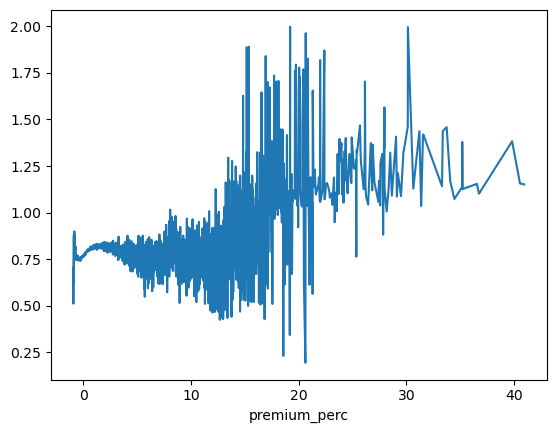

In [28]:
df_pred_results.groupby(df_pred_results['premium_perc'].round(2))['itt_hour_log_pred'].mean().plot()

<Axes: xlabel='premium_perc'>

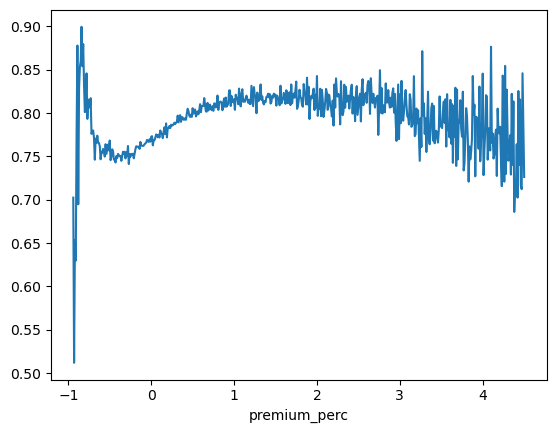

In [29]:
df_pred_results[df_pred_results['premium_perc']<=4.5].groupby(df_pred_results['premium_perc'].round(2))['itt_hour_log_pred'].mean().plot()

# B.1 Deep IV (bootstrap v1)

In [ ]:
df_bootstrap = pd.read_csv('../data/bootstrap_100iters.csv')